Requires notebook 1.

In [4]:
suppressPackageStartupMessages({
  library(dplyr)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(pagoda2)
  library(ggrepel)
  library(data.table)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [5]:
# load nsclc data
cell_annot <- prepare_nsclc_metadata(reps='one')
df <- prepare_nsclc_transcript_data(cell_annot,reps='one')
sc_obj <- prepare_nsclc_scrna()

# load pre-computed markers list
markers_full <- CachePath("nsclc_markers_list_full.tsv") %>%
  fread(sep = '\t',header=TRUE) %$%
  split(Gene, cluster)
admix_markers <- markers_full$malignant

In [6]:
# keep only genes in both spatial and sc data
g_both <- intersect(rownames(sc_obj),unique(df$gene))
df <- df[df$gene %in% g_both,]
sc_obj <- CreateSeuratObject(sc_obj[['RNA']]$counts[g_both,],meta.data=sc_obj@meta.data)

cell_annot$cell_ID <- cell_annot$cell
cell_annot <- cell_annot %$% setNames(celltype, cell_ID)

df$is_admixture <- df$gene %in% admix_markers

In [7]:
### now downsample spatial to match lib sizes in sc
# make spatial counts seurat object
so_spat <- get_counts_meta_seurat(df)
spat_dsamp <- downsample_spat(so_spat,sc_obj)
spat_dsamp_melt <- transform_sc(spat_dsamp)
spat_dsamp_melt$is_admixture <- spat_dsamp_melt$gene %in% admix_markers
d_st = spat_dsamp_melt %$% estimateAdmixtureFractions(cell, is_admixture) %>%
  mutate(cell_type=cell_annot[cell])

# excluding epithelial cells because they genuinely express some malignant cell genes
ct_include <- d_st$cell_type %>% unique() %>% .[. != 'epithelial']

[1] "Number of cells that had lib sizes downsampled:"
          DC           NK  endothelial CD4+ T cells   macrophage    malignant 
        2704          258         5130         7795            2        14000 
  fibroblast   neutrophil CD8+ T cells  plasmablast   epithelial         mast 
        2616            6         1314            0         2773          431 
     B cells         Treg     monocyte 
        7205          518          162 


Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Normalizing layer: counts



In [8]:
# process sc data into same format
sc_melt <- transform_sc(sc_obj)
sc_melt$is_admixture <- sc_melt$gene %in% admix_markers
sc_obj@meta.data$cell <- rownames(sc_obj@meta.data)
sc_obj@meta.data$cell_type <- as.character(sc_obj@meta.data$cell_type)
sc_cell_annot <- sc_obj@meta.data %$% setNames(cell_type, cell)
d_sc <- sc_melt %$% estimateAdmixtureFractions(cell, is_admixture) %>%
  mutate(cell_type=sc_cell_annot[cell])

In [9]:
# compute admixture fractions from marker genes
p_df <- list(ST=d_st, scRNA=d_sc) %>%
  estimateAdmixtureComparisonDf(cell.type.include=ct_include)

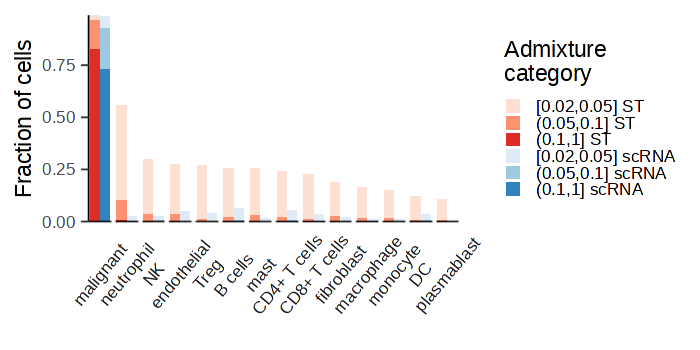

In [10]:
options(repr.plot.width = 3.5, repr.plot.height = 1.75, repr.plot.res = 200)
p <- plotAdmixtureComparison(p_df)
p

In [11]:
pdf(OutputPath("nsclc_prevalence_dsamp.pdf"), useDingbats=FALSE, width=3.5, height=1.75)
p
dev.off()

png 
  2

In [12]:
## now testing scaling the admix markers fractions down to match malignant sc
# reload the non-downsampled spatial data
so_spat_counts <- so_spat[['RNA']]$counts
so_spat_fracs <- sweep(so_spat_counts,MARGIN=2,STATS=colSums(so_spat_counts),'/')

sc_counts <- sc_obj[['RNA']]$counts
sc_fracs <- sweep(sc_counts,MARGIN=2,STATS=colSums(sc_counts),'/')

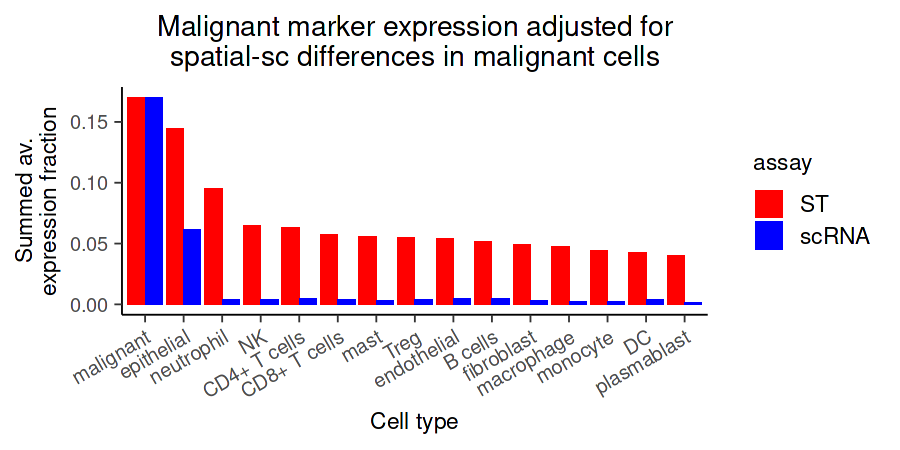

In [13]:
options(repr.plot.width = 4.5, repr.plot.height = 2.25, repr.plot.res = 200)
p2 <- plotAdmixtureCorrected(so_spat_fracs,sc_fracs,source_ct='malignant')
p2

In [14]:
pdf(OutputPath("nsclc_mark_fracs_dsamp.pdf"), useDingbats=FALSE, width=4.5, height=2.25)
p2
dev.off()

png 
  2